###  Importing all necessary files

In [1]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
from sklearn.metrics import cohen_kappa_score
import pandas as pd
from sklearn.preprocessing import StandardScaler
from Utility.ThesisUtility import printResults,readTextFromFileName,appendClustersToVector,getSentenceUsingStructringWords,getSentcesAndTokens

### Constants and Paths

In [2]:
# the path to the excel file that contains the final resutls from the clustering experiment
finalResultsPath ="Data/AnotatedData-200.xlsx"

#Sbert model
modelSbert = SentenceTransformer('all-mpnet-base-v2', device="cuda")

### Reading the data and the target from the CSV file

In [3]:
df = pd.read_excel(finalResultsPath)
y = df['AssignedLabel']  # y is the gold standards

texts = df['Text']

In [ ]:
texts

### TFIDF-Results

In [ ]:
dataFilePath = "../Dataset/Essays_all/TelevisonMergedT1+T2"
sentences = getSentcesAndTokens (dataFilePath,False)

texts_train, texts_test, y_train, y_test = train_test_split(texts, y, test_size=0.25, random_state=1000)

# buildig the vectorizer model and transforming the essays
vectorizer = TfidfVectorizer(min_df=1, stop_words='english')
vectorizer.fit_transform(sentences)
X_train = vectorizer.transform(texts_train)
X_test  = vectorizer.transform(texts_test)
X_Pred = vectorizer.transform(sentences)


#Trianing the classifier
classifier = SVC(kernel="linear")
classifier.fit(X_train, y_train)

#Evaluation
score1 = classifier.score(X_test, y_test)
pred = classifier.predict(X_test)
new_preds = classifier.predict(X_Pred)

#prinitng the results
printResults(score1,y_test,pred)

### Sbert

In [ ]:
dataFilePath = "../Dataset/Essays_all/TelevisonMergedT1+T2"
sentences = getSentcesAndTokens (dataFilePath,False)

texts_train, texts_test, y_train, y_test = train_test_split(texts, y, test_size=0.25, random_state=1000)

# buildig the vectorizer model and transforming the essays
X_trains=  []
for s in texts_train:
    X_trains.append(s)
X_tests  = []
for s in texts_test:
    X_tests.append(s)

X_train = modelSbert.encode(X_trains, show_progress_bar =True, device="cuda")
X_test  = modelSbert.encode(X_tests, show_progress_bar =True, device="cuda")
X_Pred = modelSbert.encode(sentences,show_progress_bar =True, device="cuda")

#Trianing the classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

#Evaluation
score1 = classifier.score(X_test, y_test)
pred = classifier.predict(X_test)
new_preds = classifier.predict(X_Pred)

printResults(score1,y_test,pred)

### Writing the results to Excel sheet

In [ ]:
df_test = pd.DataFrame({})
for i in  range(0,37504):
    df_test = df_test.append({
            "text": sentences[i],
            "Cluster ID": new_preds[i],
        }, ignore_index=True)
df_test.to_excel("Results - new Arguments.xlsx")

### Cross Validation

In [13]:
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)

      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }


### Plotting the results

In [12]:
# Grouped Bar Chart for both training and validation data
import matplotlib.pyplot as plt
import numpy as np

def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str,
            Name of the algorithm used for training e.g 'Decision Tree'

         y_label: str,
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str,
            This is the title of the plot e.g 'Accuracy Plot'

         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.

         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''

        # Set size of plot
        plt.figure(figsize=(24,12))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold","6th Fold", "7th Fold", "8th Fold", "9th Fold", "10th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.10000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()


In [15]:
from sklearn.model_selection import KFold
import pandas as pd

#define predictor and response variables
X = vectorizer.transform(texts)
y = df['AssignedLabel'][1:]  # y is the gold standards

_scoring = ['accuracy', 'precision', 'recall', 'f1']


#define cross-validation method to use
cv = KFold(n_splits=10, random_state=1, shuffle=True)

#build multiple linear regression model
model = LogisticRegression()

#use k-fold CV to evaluate model
# scores = cross_val_score(model, X, y, scoring='accuracy',
#                          cv=cv, n_jobs=-1)
results = cross_validate(estimator=model,
                               X=X,
                               y=y,
                               cv=cv,
                               scoring='accuracy',
                               return_train_score=True)



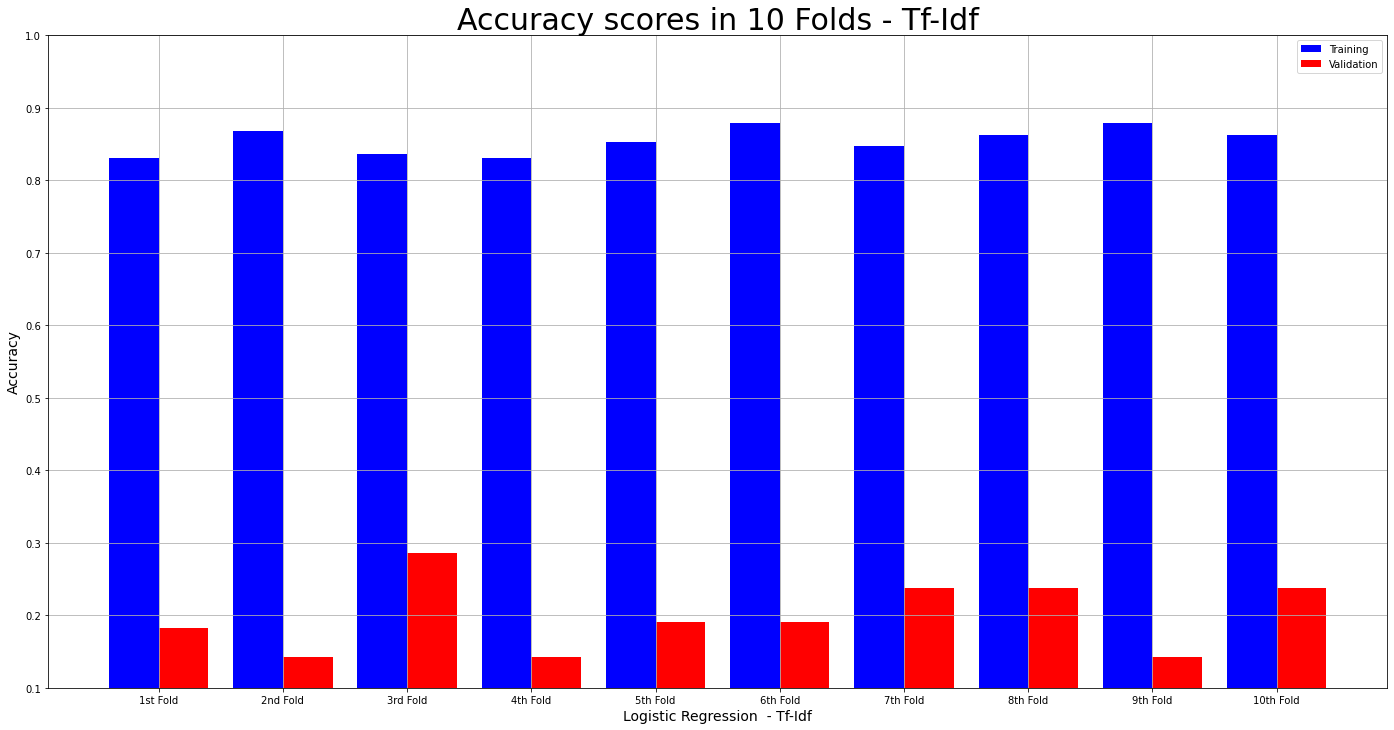

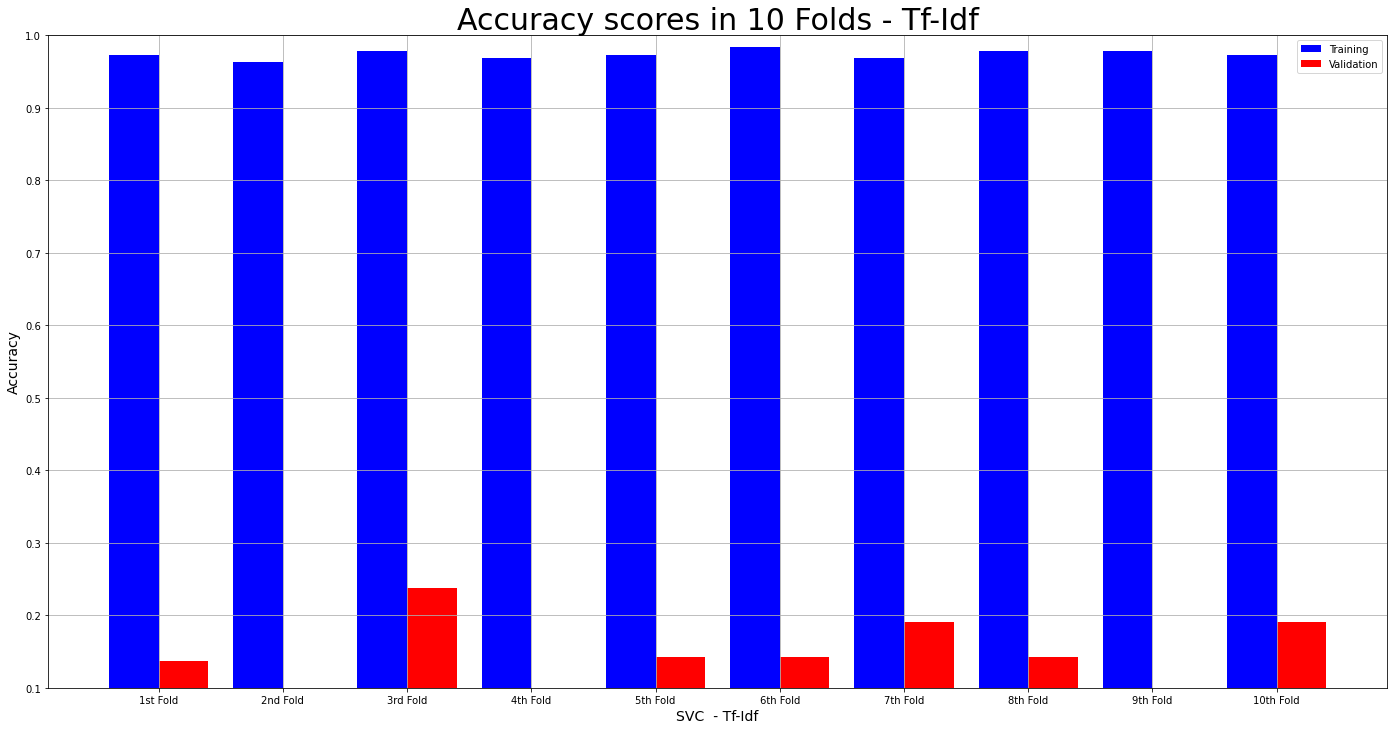

In [16]:
model_name = "Logistic Regression  - Tf-Idf"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 10 Folds - Tf-Idf",
            results["train_score"],
            results["test_score"])

#########################################################################
results = cross_validate(estimator=SVC(),
                               X=X,
                               y=y,
                               cv=cv,
                               scoring='accuracy',
                               return_train_score=True)

model_name = "SVC  - Tf-Idf"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 10 Folds - Tf-Idf",
            results["train_score"],
            results["test_score"])

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
textsnew = []
for s in texts:
    textsnew.append(s)
textsnew
X = modelSbert.encode(textsnew)

results = cross_validate(estimator=model,
                               X=X,
                               y=y,
                               cv=cv,
                               scoring='accuracy',
                               return_train_score=True)

model_name = "Logistic Regression  - Sbert "
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 10 Folds - Sbert",
            results["train_score"],
            results["test_score"])
#########################################################################
results = cross_validate(estimator=SVC(),
                               X=X,
                               y=y,
                               cv=cv,
                               scoring='accuracy',
                               return_train_score=True)

model_name = "SVC  - Sbert "
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 10 Folds - Sbert",
            results["train_score"],
            results["test_score"])


In [13]:
dfClassification = pd.read_excel("D:/USERS-Load/PycharmProjects/pythonProject/SuperVisedApproach/Results.xlsx")
dfClustering  = pd.read_excel("D:/USERS-Load/PycharmProjects/pythonProject/sbert/clusteredArgument- Sbert - 19.xlsx")

tpCount = 0

iteration = dfClassification.count()['ID']

print ("Count is" , iteration)

for i in range(0, iteration):

    clusterIDClassification = dfClassification.query(f"ID == {i}")['ClusterID'].iloc[0]
    #print("clusterIDClassification " , clusterIDClassification)

    #TextClassification = dfClassification.query(f"ID == {i}")['text'].iloc[0]
    #print("TextClassification " , TextClassification)

    clusterIDClustering =  dfClustering.query(f"ID == {i}")['AssignedLabel'].iloc[0]
    #print("clusterIDClustering " , clusterIDClustering)

    if(clusterIDClassification == clusterIDClustering):
        tpCount = tpCount + 1


accuracy = tpCount / iteration
print("The accuracy is ", accuracy * 100)  # the value is higher than the other accuracy.


Count is 37504
The accuracy is  17.435473549488055


In [14]:
print ("tpCpunt is ", tpCount)

tpCpunt is  6539


### Testing

In [ ]:
# import pandas as pd
# from numpy import mean
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
#
# # define pipeline
# #oversampler=SMOTE(kind='regular',k_neighbors=2)
#
# steps = [('over', SMOTE(k_neighbors=1)), ('model', LogisticRegression())]
# pipeline = Pipeline(steps=steps)
# # evaluate pipeline
# for scoring in["accuracy", "roc_auc"]:
#     cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=0)
#     scores = cross_val_score(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)
#     print("Model", scoring, " mean=", scores.mean() , "stddev=", scores.std())

df = pd.DataFrame({'y': [6, 8, 12, 14, 14, 15, 17, 22, 24, 23],
                   'x1': [2, 5, 4, 3, 4, 6, 7, 5, 8, 9],
                   'x2': [14, 12, 12, 13, 7, 8, 7, 4, 6, 5]})
# model_name = "Deceision Tree"
# plot_result(model_name,
#             "Accuracy",
#             "Accuracy scores in 5 Folds",
#             scores["Training Accuracy scores"],
#             scores["Validation Accuracy scores"])
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import KFold
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.linear_model import LinearRegression
# from numpy import mean
# from numpy import absolute
# from numpy import sqrt
# import pandas as pd
#
# _scoring = ['accuracy', 'precision', 'recall', 'f1']
#
# #define predictor and response variables
# X = vectorizer.transform(texts)
# y = df['AnotatedClusterID']  # y is the gold standards
#
#
# #define cross-validation method to use
# cv = KFold(n_splits=10, random_state=1, shuffle=True)
#
# #build multiple linear regression model
# model = DecisionTreeClassifier(max_depth=1)
#
# #use k-fold CV to evaluate model
# scores = cross_validation(model, X, y, 10)
#
# #view mean absolute error
# #mean(absolute(scores))
#
# # from sklearn.tree import DecisionTreeClassifier
# # svc = SVC(kernel="linear")
# # classifier.fit(X_train, y_train)
# # decision_tree_result = cross_validation(svc, X, y, 2)
# # print(decision_tree_result)